<a href="https://colab.research.google.com/github/ashu-vpu/DSIP_Project_AQI_Prediction/blob/main/Code/DSIP_Live_Prediction_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount drive to work from Google drive and Colab

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Create symbolic links to the area where the datasets are present to work with

In [6]:
!mkdir -p /content/data
!rm -rf /content/data/*.csv
!ln -s /content/drive/MyDrive/DE_Scale_Project/Datasets/All_cities/*.csv /content/data/

In [7]:
#Imports
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import joblib

import os
import time
import shutil

import threading
from datetime import datetime


Read the dataset, i.e. ALL cities Pollutant data csv file

In [8]:
def read_csv(path_to_file):
  return pd.read_csv(path_to_file)

df_All_cities_2019_2022 = read_csv('/content/data/df_All_cities_2019_2022_processed.csv')
df_All_cities_2023 = read_csv('/content/data/df_All_cities_2023.csv')

In [9]:
# Code for File streaming writer thread


def file_streaming_writer(stream_df):

  # Limit the tries for testing
  no_of_iter = 10
  counter = 0

  # Sort the DataFrame by the "year_month_date_hour" column
  sorted_stream_df = stream_df.sort_values(by="year_month_date_hour")

  # Iterate through unique hour groups and write to files
  for hour_group, group_rows in sorted_stream_df.groupby("year_month_date_hour"):
    # Define the file path for the group
    file_path = os.path.join(streaming_input_dir, f"data_{hour_group}.csv")

    # Write the group to a CSV file
    group_rows.to_csv(file_path, index=False, header=True)
    print(f"Written new file: {file_path}")

    # Temp test logic
    if counter >= no_of_iter:
      break
    counter += 1
    time.sleep(5)  # Simulate write delay



In [15]:
# Code for thread3 where we simulate an application consuming the output data from spark streaming to provide enduser update.

# Function to assign color based on the AQI value
def get_color(aqi):
    if aqi <= 50:
        return 'green'  # Good
    elif aqi <= 100:
        return 'yellow'  # Satisfactory
    elif aqi <= 200:
        return 'orange'  # Moderate
    elif aqi <= 300:
        return 'red'  # Poor
    elif aqi <= 400:
        return 'purple'  # Very Poor
    else:
        return 'maroon'  # Severe

# Define the column mapping
column_mapping = {
    'PM2p5': 'PM2.5 (µg/m³)',
    'PM10': 'PM10 (µg/m³)',
    'NO2': 'NO2 (µg/m³)',
    'CO': 'CO (mg/m³)',
    'SO2': 'SO2 (µg/m³)',
    'Ozone': 'Ozone (µg/m³)'
}

def monitor_directory(loaded_model):

    # Keep track of files already processed
    processed_files = set()

    while True:
        try:
            # List all CSV files in the directory
            files = [f for f in os.listdir(streaming_input_dir) if f.endswith('.csv')]
            # Sort files by creation time
            #files.sort(key=lambda f: os.path.getctime(f))
            #print(files)

            # Process new files
            for file_name in files:
                if file_name not in processed_files:
                    file_path = os.path.join(streaming_input_dir, file_name)
                    try:
                        # Read the CSV file into a Pandas DataFrame
                        print(f"\nNew file detected: {file_name}")
                        input_df = pd.read_csv(file_path)
                        # Rename the columns
                        input_df = input_df.rename(columns=column_mapping)

                        # Ensure the necessary columns exist in the DataFrame
                        columns_for_prediction = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO2 (µg/m³)', 'CO (mg/m³)', 'SO2 (µg/m³)', 'Ozone (µg/m³)']
                        target = "AQI"

                        # Generate predictions
                        input_df["pred_AQI"] = loaded_model.predict(input_df[columns_for_prediction])

                        # Select required columns
                        df = input_df[["City", "Timestamp", "pred_AQI", "AQI"]]

                        # Ensure the required columns exist
                        if 'City' in df.columns and 'pred_AQI' in df.columns:

                            #print(f"Generating bar plot for {file_name}...")

                            #timestamp = df['Timestamp'].strftime("%Y%m%d%H")
                            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
                            first_timestamp = df['Timestamp'].iloc[0]
                            date_str = first_timestamp.strftime("%Y-%m-%d")
                            hour = first_timestamp.hour
                            timestamp = f"Date: {date_str} Hour: {hour}"

                            # Assign colors based on pred_AQI values
                            colors = df['pred_AQI'].apply(get_color)
                            # Create a bar plot
                            plt.figure(figsize=(10, 6))
                            plt.bar(df['City'], df['pred_AQI'], color=colors)
                            plt.xlabel("City")
                            plt.ylabel("pred_AQI")
                            plt.title(f"AQI Values by City for: ({timestamp})")
                            plt.xticks(rotation=45, ha='right')
                            plt.tight_layout()

                            # Show the plot
                            plt.show()
                        else:
                            print(f"File {file_name} does not contain 'City' and 'Aqi' columns.")

                    except Exception as e:
                        print(f"Error reading {file_name}: {e}")
                    # Mark file as processed
                    processed_files.add(file_name)
                    print(f"\nProcessed file: {file_name}")

            # Wait for a short interval before checking again
            time.sleep(1)
        except Exception as e:
            print(f"Error monitoring directory: {e}")
            break



Written new file: /content/streaming_input_dir/data_2023-01-01-00.csv

New file detected: data_2023-01-01-00.csv


<ipython-input-15-47a185f488dd>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


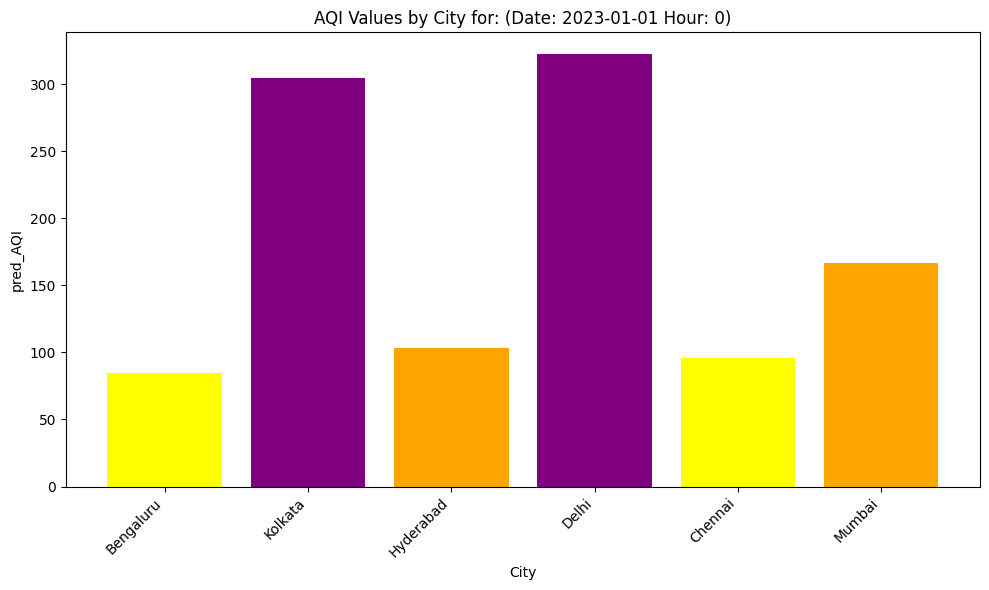


Processed file: data_2023-01-01-00.csv
Written new file: /content/streaming_input_dir/data_2023-01-01-01.csv

New file detected: data_2023-01-01-01.csv


<ipython-input-15-47a185f488dd>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


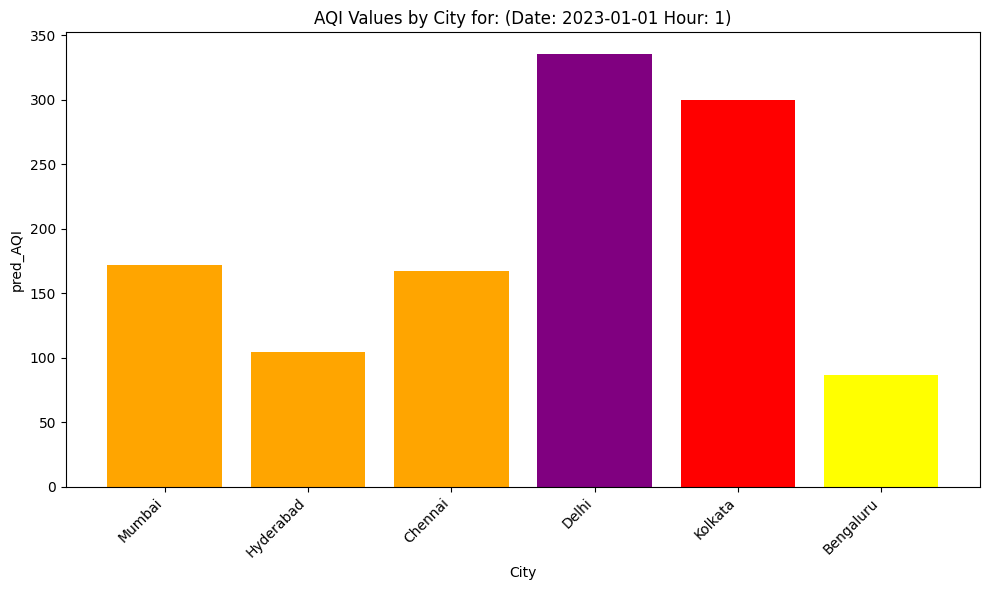


Processed file: data_2023-01-01-01.csv
Written new file: /content/streaming_input_dir/data_2023-01-01-02.csv

New file detected: data_2023-01-01-02.csv


<ipython-input-15-47a185f488dd>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


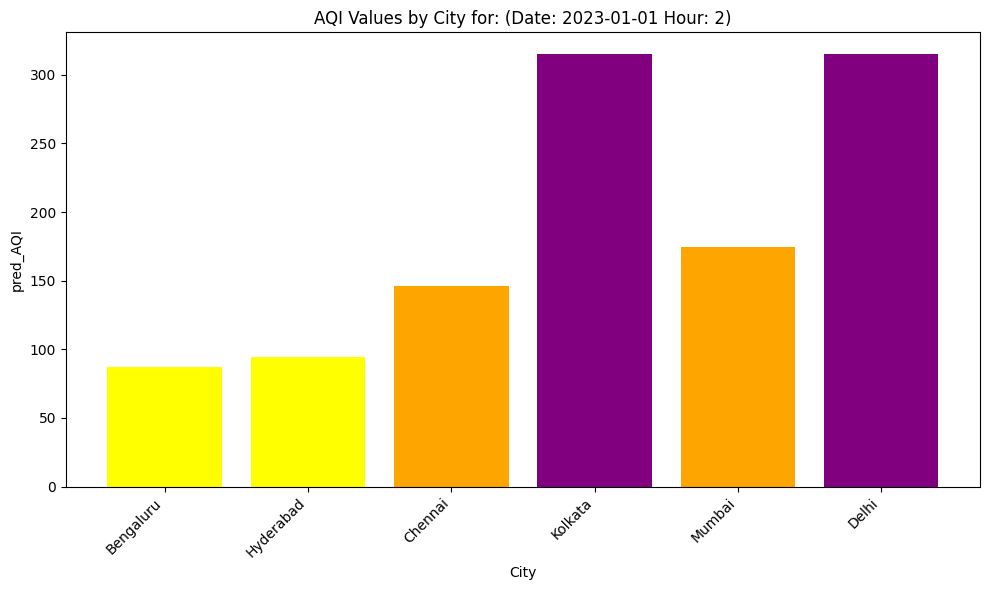


Processed file: data_2023-01-01-02.csv
Written new file: /content/streaming_input_dir/data_2023-01-01-03.csv

New file detected: data_2023-01-01-03.csv


<ipython-input-15-47a185f488dd>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


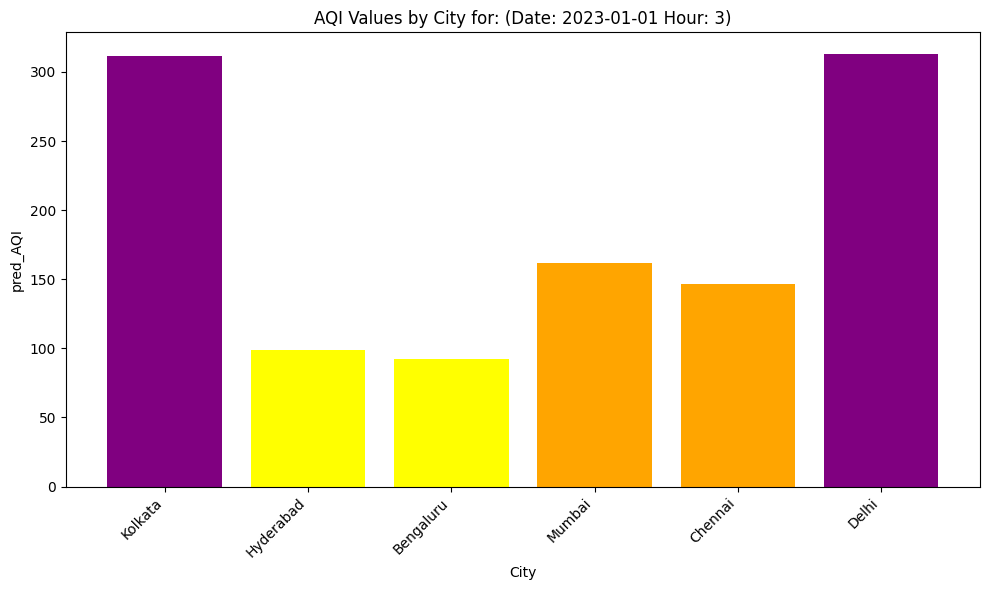


Processed file: data_2023-01-01-03.csv
Written new file: /content/streaming_input_dir/data_2023-01-01-04.csv

New file detected: data_2023-01-01-04.csv


<ipython-input-15-47a185f488dd>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


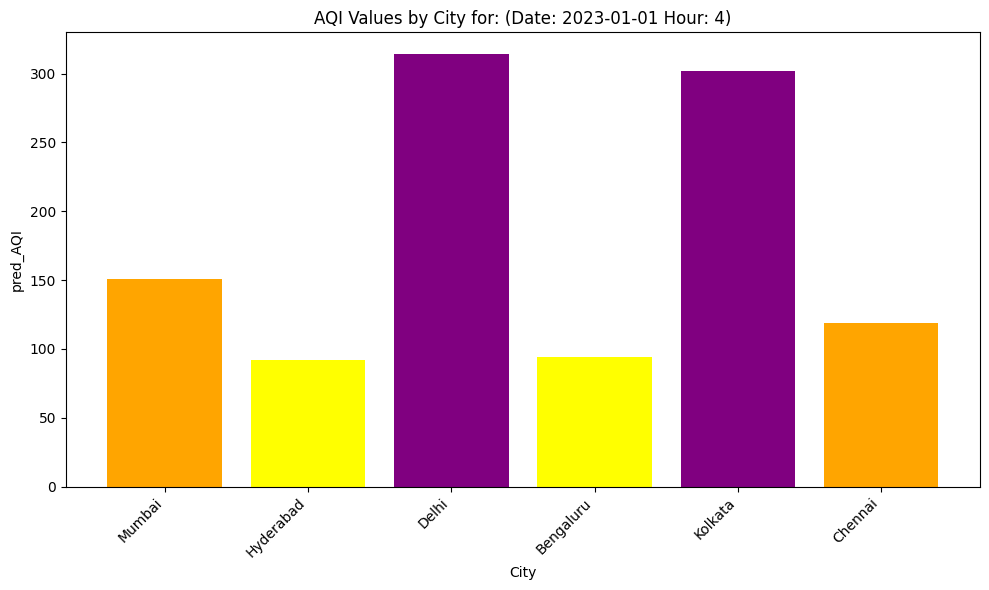


Processed file: data_2023-01-01-04.csv
Written new file: /content/streaming_input_dir/data_2023-01-01-05.csv

New file detected: data_2023-01-01-05.csv


<ipython-input-15-47a185f488dd>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


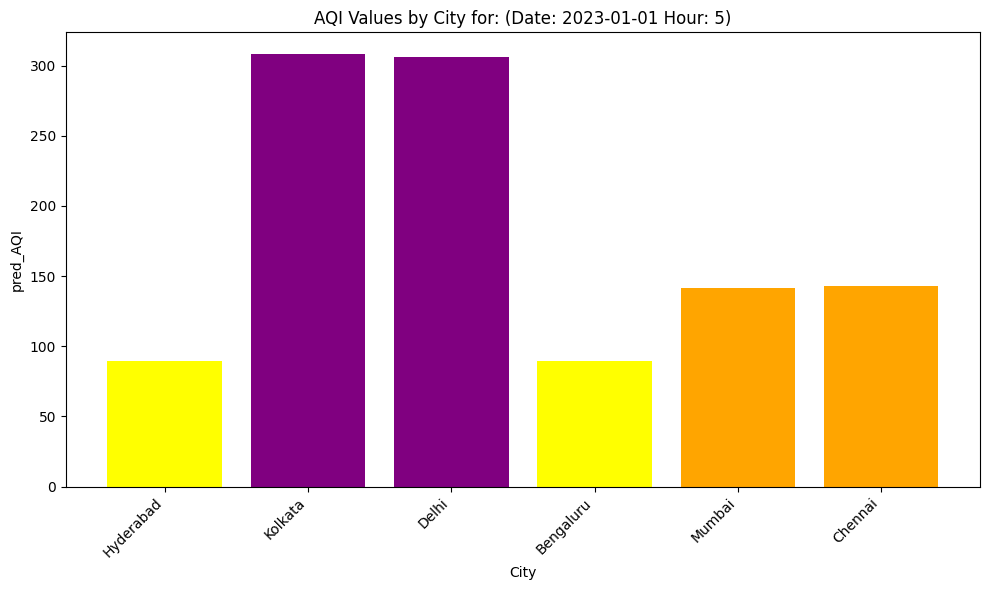


Processed file: data_2023-01-01-05.csv
Written new file: /content/streaming_input_dir/data_2023-01-01-06.csv

New file detected: data_2023-01-01-06.csv


<ipython-input-15-47a185f488dd>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


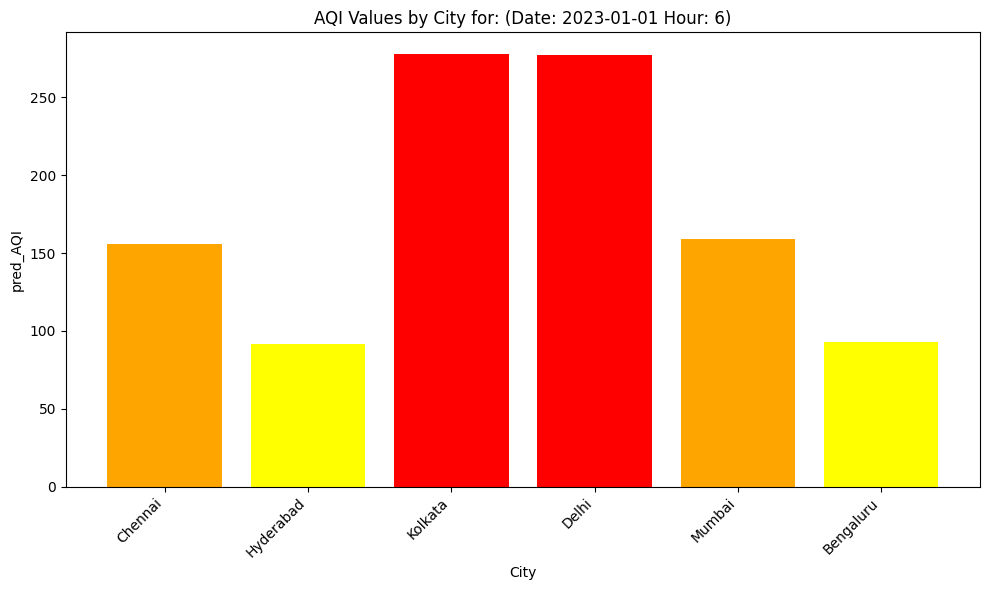


Processed file: data_2023-01-01-06.csv
Written new file: /content/streaming_input_dir/data_2023-01-01-07.csv

New file detected: data_2023-01-01-07.csv


<ipython-input-15-47a185f488dd>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


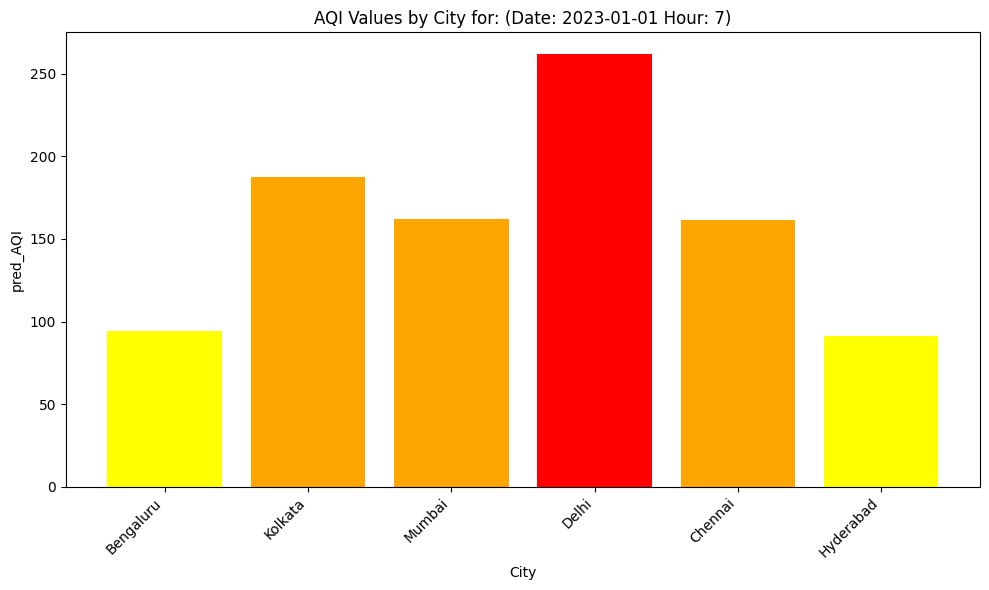


Processed file: data_2023-01-01-07.csv
Written new file: /content/streaming_input_dir/data_2023-01-01-08.csv

New file detected: data_2023-01-01-08.csv


<ipython-input-15-47a185f488dd>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


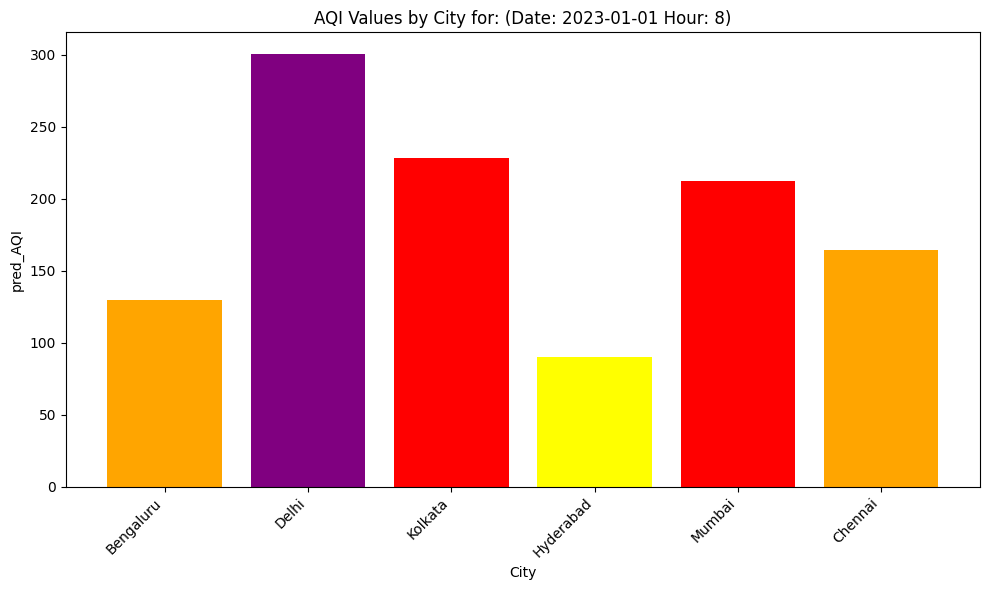


Processed file: data_2023-01-01-08.csv
Written new file: /content/streaming_input_dir/data_2023-01-01-09.csv

New file detected: data_2023-01-01-09.csv


<ipython-input-15-47a185f488dd>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


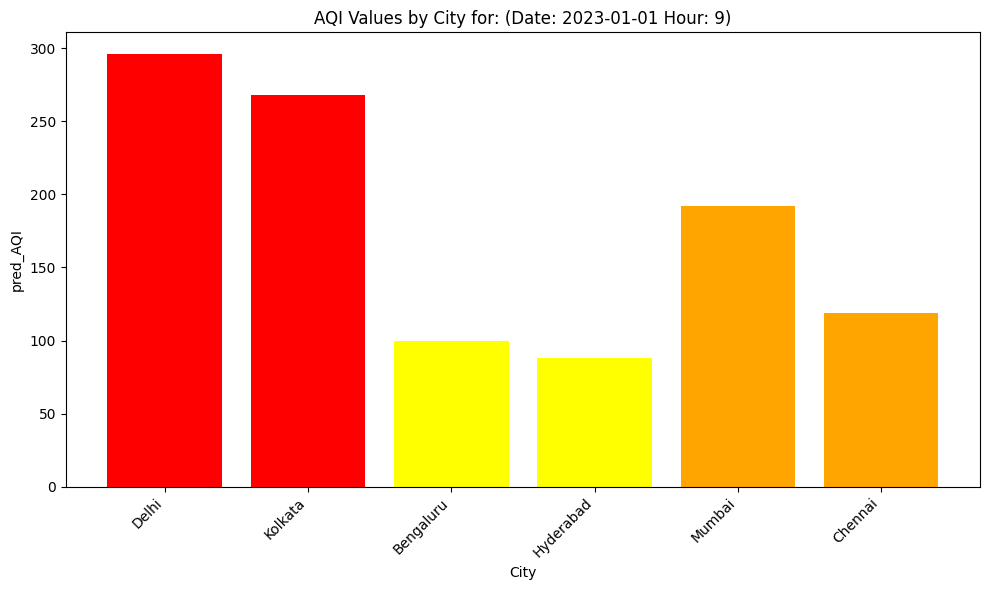


Processed file: data_2023-01-01-09.csv
Written new file: /content/streaming_input_dir/data_2023-01-01-10.csv

New file detected: data_2023-01-01-10.csv


<ipython-input-15-47a185f488dd>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


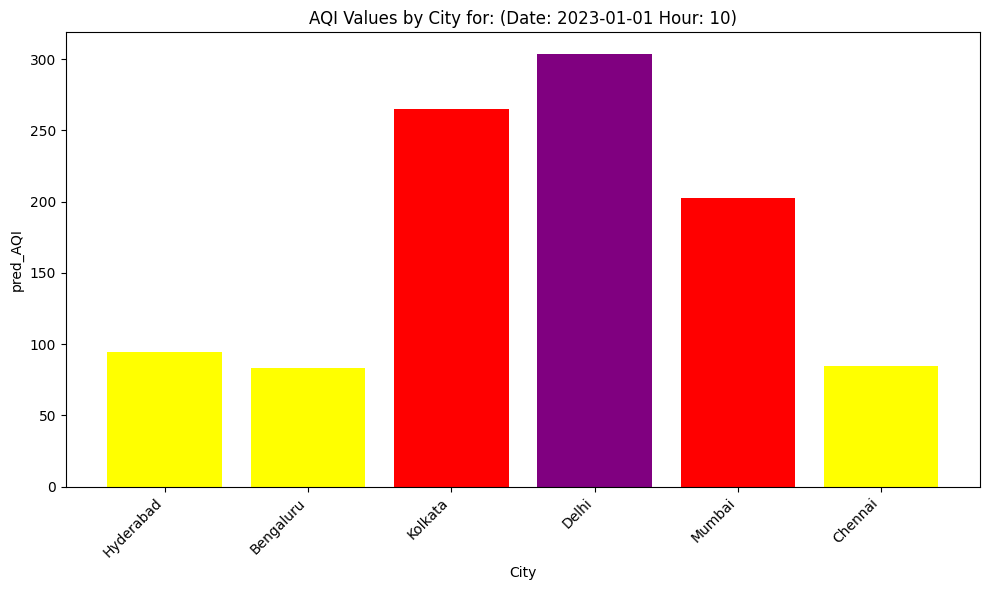


Processed file: data_2023-01-01-10.csv


In [16]:
# Driver Code

# Main function to run both threads
def main(pollutant_data_2023):
    # Thread 1: File streaming writer
    file_writer_thread = threading.Thread(target=file_streaming_writer, args=(pollutant_data_2023,), daemon=True)

    # Load the pre-trained model
    model_path="/content/drive/MyDrive/DE_Scale_Project/DSIP_rf_rscv_model"
    saved_model = joblib.load(model_path)

    #Thread2: Monitor directory
    monitor_directory_thread = threading.Thread(target=monitor_directory, args=(saved_model,), daemon=True)

    # Start threads
    file_writer_thread.start()
    monitor_directory_thread.start()

    # Wait for both threads to complete
    file_writer_thread.join(timeout=120)
    monitor_directory_thread.join(timeout=120)

if __name__ == "__main__":

  # Ensure the 'Timestamp' column is in datetime format
  df_All_cities_2023['Timestamp'] = pd.to_datetime(df_All_cities_2023['Timestamp'])

  # Create the 'year_month_date_hour' column
  df_All_cities_2023['year_month_date_hour'] = df_All_cities_2023['Timestamp'].dt.strftime('%Y-%m-%d-%H')

  streaming_input_dir = "/content/streaming_input_dir"
  # Delete if this already exists
  if os.path.isdir(streaming_input_dir):
    shutil.rmtree(streaming_input_dir)  # Delete the directory
  os.makedirs(streaming_input_dir, exist_ok=True)

  main(df_All_cities_2023)


